# Erros de classificação e test time augmentation

1. Treinar uma resnet 18 para classificar o dataset Oxford Pets, ou utilizar o checkpoint da disciplina;
2. Identificar as 10 imagens de cachorro do conjunto de validação para as quais o modelo "mais errou", ou seja, o modelo associou a menor probabilidade de ser cachorro. Fazer o mesmo para as imagens da classe gato;
3. Realizar a técnica "test time augmentation" e verificar se as probabilidades dessas 10 imagens melhoram. 

A técnica "test time augmentation" consiste em criar diversas versões da mesma imagem usando data augmentation, aplicar o modelo nas imagens aumentadas e calcular a média das probabilidades nas imagens

### Albumentations
A computer vision tool that boosts the performance of deep convolutional neural networks

https://albumentations.ai/

https://github.com/albumentations-team/albumentations

In [1]:
import matplotlib.pyplot as plt
import torch
import dataset
import albumentations as A
import numpy as np

from torch import nn
from torchvision import models


# Os pesos do modelo foram salvos quando ele estava na GPU. Por padrão, o Pytorch
# carrega o modelo no mesmo device no qual ele foi salvo. Para evitar erro caso
# uma GPU não esteja disponível, usamos o parâmeto `map_location`
checkpoint = torch.load('data/checkpoints/M06/checkpoint.pt', map_location='cpu')
checkpoint.keys()

dict_keys(['params', 'model', 'optim', 'sched', 'logger'])

In [5]:
ds_train, ds_valid, class_weights = dataset.get_dataset('data')
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(checkpoint['model'])
model.eval();

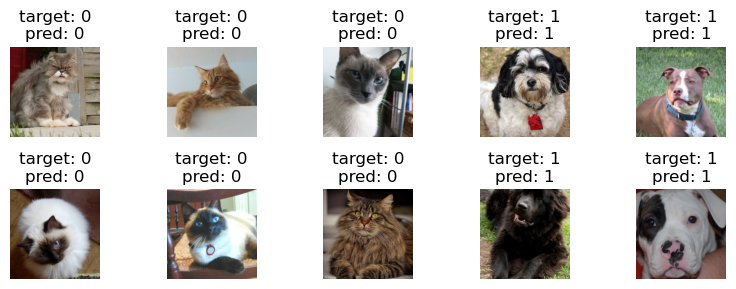

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(8,3))
axs = axs.reshape(-1)
for idx in range(10):
    img, target = ds_valid[idx]
    with torch.no_grad():
        scores = model(img.unsqueeze(0))
        pred = torch.argmax(scores)
    axs[idx].imshow(dataset.unormalize(img))
    axs[idx].set_title(f'target: {target}\npred: {pred}')
    axs[idx].set_axis_off()
plt.tight_layout()

In [8]:
imgs_idx = []
for idx in range(len(ds_valid)):
    img, target = ds_valid[idx]
    with torch.no_grad():
        scores = model(img.unsqueeze(0))
        pred = torch.argmax(scores)
    if pred != target:
        imgs_idx.append(idx)
        print(f"{pred} != {target}")


1, 0
1, 0
1, 0
1, 0
1, 0
1, 0
1, 0
1, 0
1, 0
0, 1
1, 0
1, 0
0, 1
0, 1
1, 0
1, 0
1, 0
0, 1
1, 0
0, 1
0, 1
1, 0


In [ ]:
def aug(x):
    y=[]
    # Blur transforms
    transform = A.Blur(always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # Center crop and resize
    transform = A.Compose([
        A.CenterCrop (150, 150, always_apply=False),
        A.Resize (224, 224, interpolation=1, always_apply=True) 
    ])
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # RandomCrop and resize
    transform = A.Compose([
        A.RandomCrop(150, 150, always_apply=False),
        A.Resize (224, 224, interpolation=1, always_apply=True) 
    ])
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # Elastic Transform
    transform = A.ElasticTransform(alpha=1, always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # Grid Distortion
    transform = A.GridDistortion(always_apply=True) 
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # PixelDropout
    transform = A.PixelDropout (always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # RandomRotate90
    transform = A.RandomRotate90(always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # RandomBrightnessContrast
    transform = A.RandomBrightnessContrast(always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # Geometric transforms
    transform = A.Affine(always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))

    # ChannelDropout
    transform = A.ChannelDropout(always_apply=True)
    y.append(torch.from_numpy(transform(image=np.asanyarray(img))['image']).permute(2, 0, 1))
    return y


In [10]:
img, target = ds_valid[28]
img = dataset.unormalize(img)
imgs = torch.stack(aug(img))

In [15]:
for idx in imgs_idx:
    img, target = ds_valid[idx]
    
    # Cria batch com 10 versões aumentadas da mesma imagem
    img = dataset.unormalize(img)
    imgs = torch.stack(aug(img))

    with torch.no_grad():
        scores = model(imgs.float())
    probs = scores.softmax(dim=1)

    # Média das probabilidades para as 10 versões da mesma imagem
    probs_tta = probs.mean(dim=0)

    print(f"{torch.argmax(probs_tta)}, {target}")

1, 0
0, 0
0, 0
1, 0
0, 0
1, 0
0, 0
0, 0
0, 0
0, 1
0, 0
0, 0
0, 1
0, 1
0, 0
0, 0
0, 0
0, 1
0, 0
0, 1
0, 1
0, 0
